In [1]:
import pandas as pd
from src.pca import plot_pca, get_cmap, scatter_plot

import matplotlib.pyplot as plt

from src.get_data import read_precip, read_QTC
from src.preprocessing import clean_precip, clean_QTC
from src.plots import plot_interpolated_ts, plot_hydrographs
from src.split_events import split_events, filter_events
from src.EMUA import add_old_water
from src.h_index import get_h_index
from src.event_metrics import get_event_matrix
from src.time_series_plot import plot_time_series

import warnings
warnings.filterwarnings("ignore")


In [2]:
#Data sources
precip_path = "./Data/2922906.csv"
QTC_path    = "./Data/formattedTimeSeries.csv"

# Get raw data
precip_raw = read_precip(precip_path)
QTC_raw    = read_QTC(QTC_path)

#Clean data
precip_clean = clean_precip(precip_raw) # resample to hourly P
QTC_clean = clean_QTC(QTC_raw) # interpolate small gaps, remove outliers

# add event flag
QTC_flagged = split_events(QTC_clean)

# Add old water estimation
QTCO = add_old_water(QTC_flagged)

# add TSS and Load
QTCO['TSS'] = QTCO['combinedTurb'].multiply(1.217).add(7.5215)
QTCO['load_mgs']=QTCO['TSS'].multiply(QTCO['Qcms'])

#filter events -> remove events with incomplete data 
Events_ts = filter_events(QTCO) # time series with flagged (final) events

#Events_matrix = get_event_matrix(Events_ts, precip_clean, QTCO)

# Save results in local drive

In [24]:
# File to be used by the model calibration algorithm 
output_path = './Outputs/Event_Matrix.csv'

Events_matrix.to_csv(output_path)

# Plots

In [3]:
data_file = './Outputs/Event_Matrix.csv'
Events_matrix = pd.read_csv(data_file,
                        header = [0,1],
                        index_col = [0]
                        )
# Events_matrix.dropna(inplace=True)
Events_matrix.columns = Events_matrix.columns.get_level_values(1)

## PCA plot

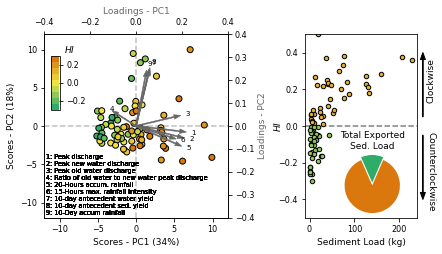

In [4]:
from importlib import reload
import sys
reload(sys.modules["src.pca"])
from src.pca import plot_pca, get_cmap, scatter_plot


cmap = get_cmap()
vminmax = (-0.3,0.3)
# arrow_colors = [cmap(0)]*3 + [cmap(0.5)]*3 + [cmap(1.0)]*5


subset_predictors = ["max_bf", "max_qf", "peakFlow", "bf_qf_peak_ratio","P_20h_acum","P_20h_max_i","cum_Qcm_10D","P_10d_acum","load_10D" ]
subset_predictors = ["peakFlow","max_qf","max_bf", "bf_qf_peak_ratio","P_20h_acum", "P_15h_max_i","cum_Qcm_10D","load_10D","P_10d_acum"]
arrow_colors = [(0.4,0.4,0.4)]*len(subset_predictors)
X = Events_matrix.drop('h', axis = 1)
y = Events_matrix['h']

fig  = plt.figure(figsize=(6.25,3), facecolor='white')
ax_pca = fig.add_axes(rect = [0.1, 0.1, 0.45, 0.85])
ax_scatter = fig.add_axes(rect = [0.70, 0.1, 0.25, 0.85])


#fig, ax_pca = plt.subplots(1,1, figsize = (3,3))
#fig, ax_scatter = plt.subplots(1,1, figsize = (2.3,3))

plot_pca(ax_pca, X, y, subset_predictors_plot = subset_predictors, arrow_colors = arrow_colors, score_cmap = cmap, vminmax = vminmax )

load_kg = X["totalLoad"]*15*60/(1e6) # [mg/s]*(15*60s)/1e6 mg/kg  
scatter_df = pd.concat((load_kg, y), axis = 1)
scatter_plot(ax_scatter, scatter_df)


plt.savefig("./Outputs/Figures/PCA.png", dpi = 500, facecolor = "white", bbox_inches = "tight")

## Time Series

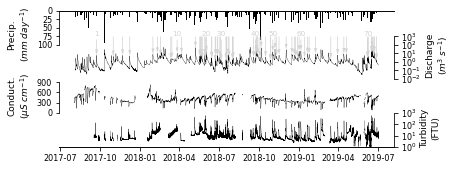

In [5]:
%matplotlib inline

from importlib import reload
import sys
reload(sys.modules["src.time_series_plot"])
from src.time_series_plot import plot_time_series

plot_time_series(QTC_clean, precip_clean, Events_ts)
# plt.savefig("./Outputs/Figures/TimeSeries.png", dpi = 300, facecolor = "white", bbox_inches = "tight")

In [ ]:

fig, axs = plt.subplots(2,1, sharex = True)
axs[0].plot(QTCO.combinedTurb)
axs[1].plot(QTCO.combinedTurb)
axs[1].set_yscale("log")

# Event example

In [10]:
from src.pca import get_cmap
import configparser
config = configparser.ConfigParser()
config.read('fig_params.txt')
font_sizes = config["Fonts_paper"]
cmap = get_cmap()

### Hysteresis loops with time series

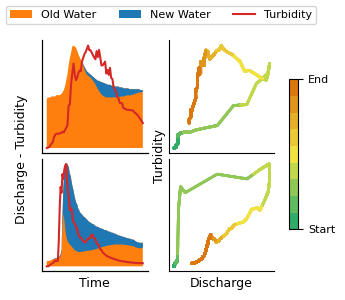

In [27]:
%matplotlib inline
events = (106, 120)
keep_fract = (0.3,0.3)
fig, axs = plt.subplots(2,2, figsize = (3,3))

for event, (ax1, ax2), frac in zip(events,axs, keep_fract):
    axturb = ax1.twinx()
    ev_ts = QTCO.loc[QTCO.Event_ID == event,['Qcms','Q_bf','Q_qf','combinedTurb']]
    n = len(ev_ts)
    ev_ts = ev_ts.iloc[:int(n*frac)]
    ev_ts_hr = ev_ts[["Qcms","combinedTurb"]].resample("10S").interpolate()
    ev_ts_hr["time"] = (ev_ts_hr.index - ev_ts_hr.index[0]).total_seconds()  
    
    ax1.fill_between(ev_ts.Q_bf.index,ev_ts.Qcms, color = "tab:orange", edgecolor= None, label = "Old Water" )
    ax1.fill_between(ev_ts.index,ev_ts.Qcms,ev_ts.Q_bf, color = "tab:blue", edgecolor= None, label = "New Water")
    turb_hnd = axturb.plot(ev_ts.combinedTurb, color = "tab:red", label = "Turbidity")
    ax1.set_xticks([],[])
    ax1.set_yticks([],[])
    axturb.set_yticks([],[])

    sc = ax2.scatter(ev_ts_hr["Qcms"], ev_ts_hr["combinedTurb"], c = ev_ts_hr["time"], cmap = cmap, vmin = 0, vmax = 50000, s = 1)
    ax2.set_xticks([],[])
    ax2.set_yticks([],[])
    
    ax1.spines[["top", "right"]].set_visible(False)
    axturb.spines[["top", "right"]].set_visible(False)
    ax2.spines[["top", "right"]].set_visible(False)

plt.annotate("Discharge - Turbidity", xy = (0.07,0.47), xycoords = "figure fraction", rotation = 90, ha = "center", va = "center", fontsize = font_sizes.getint("label"))
axs[1,0].set_xlabel("Time", fontsize = font_sizes.getint("label"))
axs[1,1].set_xlabel("Discharge", fontsize = font_sizes.getint("label"))
plt.annotate("Turbidity", xy = (0.53,0.48), xycoords = "figure fraction", rotation = 90, ha = "center", va = "center", fontsize = font_sizes.getint("label"))



fig.subplots_adjust(hspace = 0.05, wspace = 0.2)
cb_ax = fig.add_axes([0.95,0.25,0.03,0.5])
plt.colorbar(mappable=sc, cax = cb_ax, ticks = [0,50000])
cb_ax.set_yticklabels(["Start","End"], fontsize = font_sizes.getint("tick_label"))
hnd1, lab1 = ax1.get_legend_handles_labels()

fig.legend(hnd1+turb_hnd, lab1 + ["Turbidity"], fontsize = font_sizes.getint("tick_label"), ncols = 3, loc = "upper left")

plt.savefig("./Outputs/Figures/events_example.png", dpi = 300, facecolor = "white", bbox_inches = "tight")

### Only New/Old water

# Events timing

In [5]:
import datetime

In [4]:
# get time limits of an event discarding 'frac' fraction of the event at each tail 
def get_time_limits(time_series, frac = 0.1): 
    integral      = time_series.cumsum()[-1] - time_series[0]
    min_val       = time_series[0] + integral*frac
    t0            = event_ts.loc[time_series.cumsum()<min_val].index[-1]
    max_value     = time_series.cumsum()[-1] - integral*frac
    tf            = time_series.loc[time_series.cumsum()>max_value].index[0]
    mean_value    = time_series.cumsum()[-1] - integral*0.5
    t_mean        = time_series.loc[time_series.cumsum()<=mean_value].index[-1]
    return (t0,tf,t_mean)

In [6]:
Full_featuresDF = Events_matrix.copy()
full_ts = QTCO.copy()

times_DF_list = []
for id_ in Full_featuresDF.index:
    
    # Filter event
    event_ts = full_ts.loc[full_ts.Event_ID==id_]
    
    # time of peak flow
    t_peak = event_ts.Qcms.idxmax()

    # cut event 
    end_ev   = t_peak+datetime.timedelta(hours=10)
    event_ts = event_ts.loc[:end_ev] 


    # times turbidity
    t0_turb, tf_turb, tm_turb = get_time_limits(event_ts.combinedTurb, frac = 0.1)
    tpeak_turb                = event_ts.combinedTurb.idxmax()

    # times base flow
    t0_bf, tf_bf, tm_bf = get_time_limits(event_ts.Q_bf, frac = 0.1)
    tpeak_bf            = event_ts.Q_bf.idxmax()

    # times quick flow
    t0_qf, tf_qf, tm_qf = get_time_limits(event_ts.Q_qf, frac = 0.1)
    tpeak_qf            = event_ts.Q_qf.idxmax()

    DF_times = (pd.DataFrame({'BF'      :[t0_bf,    tpeak_bf,    tf_bf, tm_bf],
                              'QF'      :[t0_qf,    tpeak_qf,    tf_qf, tm_qf],
                              'Turb'    :[t0_turb,  tpeak_turb,  tf_turb, tm_turb]
                              }, 
                             index = ['t0', 'tpeak', 'tf', 'tmean']
                             ) - t_peak).applymap(lambda x: x.total_seconds()/3600)
    DF_times['Event_ID'] = id_
    
    DF_row = DF_times.reset_index().pivot(index = 'Event_ID', columns='index')
    times_DF_list.append(DF_row)
    
DF_times_all = pd.concat(times_DF_list)
DF_times_all[('Response','h')] = Full_featuresDF['h']
# DF_times_all[('P_event','P_15h_acum')] = Full_featuresDF['P_event']['P_15h_acum']

# add signal duration

for var in ['BF','QF','Turb']:
    DF_times_all[(var,'dur')] = DF_times_all[var]['tf'] - DF_times_all[var]['t0']

In [7]:
bins = [-0.3,-0.15,0,0.15,.3,0.51]
categs = pd.cut(Full_featuresDF['h'], bins = bins)
categs.rename('categ',inplace=True)
DF_times_all[('Response','categ')] = categs
categories = DF_times_all['Response']['categ'].unique().sort_values()

# Total load calculations
load_DF = DF_times_all['Response']['categ'].to_frame().join(Full_featuresDF['totalLoad'].to_frame()).groupby('categ')['totalLoad'].mean()


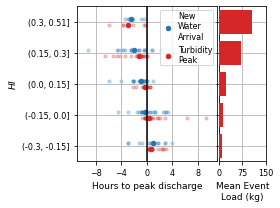

In [11]:

colors = ['#E09F3E','#9E2A2B','#335C67']
colors = ["#1E6C41", "#B1620B"]
colors = ['#335C67','#9E2A2B']

title_str = {'tpeak': 'Peak Time', 'tmean':'Center Time','t0': 'Start Time','tf': 'End Time' }


fig, axs =plt.subplots(1,2, figsize = (4,3), sharey = True, gridspec_kw={'width_ratios': [3, 1]})

ax=axs[0]
ax.plot([0,0],[0,6],'k')
ypos = [1,2,3,4,5]
for i, catego in enumerate(categories):
    subset = DF_times_all.loc[DF_times_all['Response']['categ'] == catego]
    leng = len(subset['QF'])

    #Quick Flow
    ax.scatter(subset['QF']['t0'],                [ypos[i] + 0.1]*leng, 
               c = "tab:blue", alpha = 0.25, s = 10)
    sc1 = ax.scatter(subset['QF']['t0'].median(), ypos[i] + 0.1,        
                     c = "tab:blue", alpha = 1, marker = 'o', s = 20, label='New\nWater\nArrival')

    # Turbidity
    ax.scatter(subset['Turb']['tpeak'],                [ypos[i] - 0.1      ]*leng, 
               c = "tab:red", alpha = 0.25, s = 10)
    sc2 = ax.scatter(subset['Turb']['tpeak'].median(), ypos[i] - 0.1     ,          
                     c = "tab:red", alpha = 1,  marker = 'o', s = 20, label='Turbidity\nPeak')


ax.grid(True)

ax.set_ylim(0.5,5.5)
ax.set_xlim(-10,10)

#add legend to plot
#get handles and labels
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[0:2],labels[0:2], fontsize = font_sizes.getint("tick_label"), 
loc = 'upper right',  frameon = True, handletextpad = 0.2, borderpad = 0.1
)
#bbox_to_anchor = (0.75,0.95),
ax.set_yticks([1,2,3,4,5])
ax.set_yticklabels(categories)
ax.set_ylabel('$HI$', fontsize=font_sizes.getint("label"))
ax.set_xlabel('Hours to peak discharge',fontsize=font_sizes.getint("label"))
ax.tick_params('both', labelsize = font_sizes.getint("tick_label"))
ax.set_xlim(-11,11)
ax.set_xticks([-8, -4, 0, 4, 8])
# ax.set_title(title_str[variable],fontsize=18)

# # Barplot
axb = axs[1]
axb.grid(True)
axb.barh(ypos,load_DF*15*60/1e6, color = "tab:red", zorder = 3)
#axb.spines[["top","right"]].set_visible(False)
#axb.grid(True, zorder = -1, linestyle = "--")
axb.set_xlabel('Mean Event\nLoad (kg)', fontsize = font_sizes.getint("label"))
axb.tick_params('both', labelsize = font_sizes.getint("tick_label"))
axb.set_xlim(0,150)
axb.set_xticks([0, 75, 150])

fig.tight_layout()
plt.subplots_adjust(wspace=0.02)
# fig.savefig("./Outputs/Figures/timings.png", facecolor='w', dpi = 300, bbox_inches = "tight")